In [1]:
!pip install pystan==2.19.1.1 fbprophet >/dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet
import statsmodels.api as sm

from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

import sys
sys.path.append('..')
from src.data.dataset_generator import DatasetGenerator

In [3]:
dg = DatasetGenerator(['montel'])
data = dg.get_dataset('2016-01-01', '2020-01-01', 'T23')
data_frame = data.copy()
df = data.copy()
data_f = data.copy()
X = data.Time
Y = data.SPOTPrice

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))
data.head(5)

Number of datapoints in the Dataset: 35087
Minimum date from data set: 2016-01-01 00:00:00
Maximum date from data set: 2020-01-01 23:00:00


,Time,SPOTPrice
0,2016-01-01 00:00:00,23.86
1,2016-01-01 01:00:00,22.39
2,2016-01-01 02:00:00,20.59
3,2016-01-01 03:00:00,16.81
4,2016-01-01 04:00:00,17.41


In [4]:
# unit: €/MWh
data.describe()

,SPOTPrice
count,35088.000000
mean,36.429771
std,16.863341
min,-130.090000
25%,27.590000
50%,35.650000
75%,45.430000
max,163.520000


In [5]:
data = data.set_index('Time')
data.index = pd.to_datetime(data.index)

In [6]:
data_res = data.resample('1W').mean()

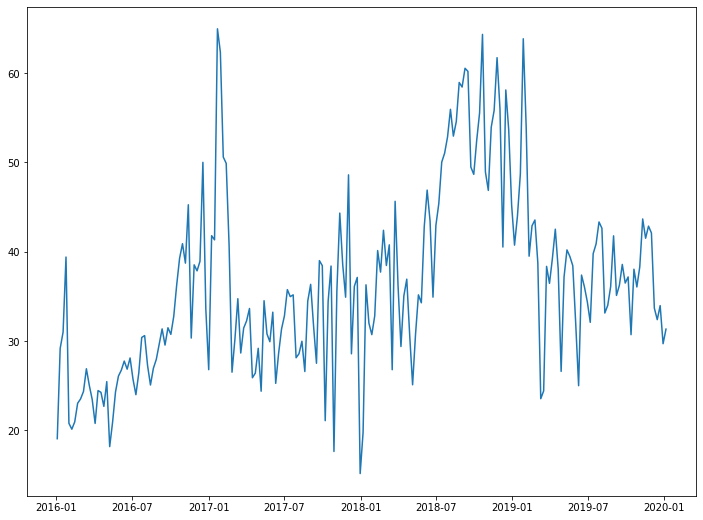

In [7]:
x = data_res.index
y = data_res.SPOTPrice

plt.figure(figsize=(12, 9))
plt.plot(x,y)
plt.show()

## Prophet on whole data set + future data set

In [8]:
#switch column names to prophet structure
data_frame.rename(columns = {'Time': 'ds', 'SPOTPrice': 'y'}, inplace = True)

In [9]:
pro = Prophet()
pro.add_country_holidays(country_name='Germany')
pro.fit(data_frame)

Initial log joint probability = -208.905


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       74610.2     0.0135483       4572.87           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       74805.6    0.00772887       2875.42           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         74876    0.00381129        733.92      0.3293      0.3293      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       74901.6     0.0154041        674.33           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       74940.9     0.0156012       1764.82           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [10]:
future = pro.make_future_dataframe(periods = 300)

In [11]:
forecast = pro.predict(future)

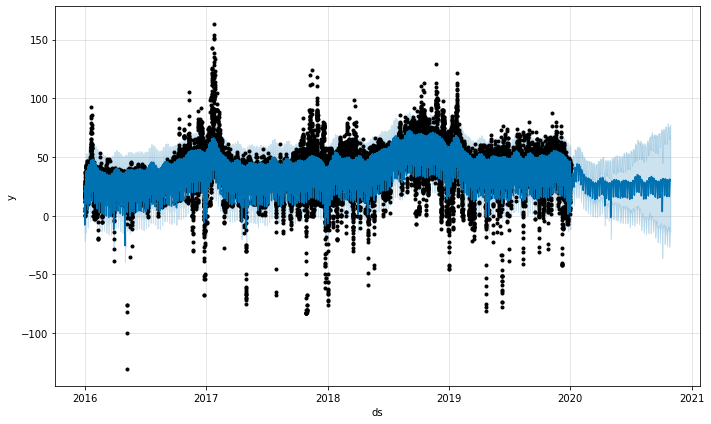

In [12]:
fig = pro.plot(forecast)

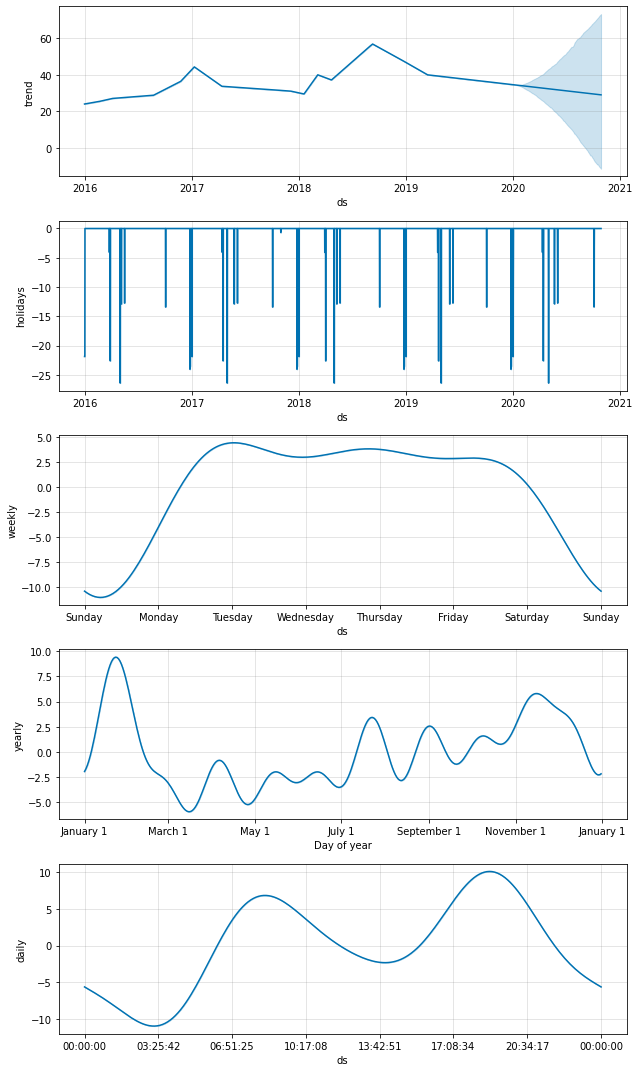

In [13]:
# components the model uses for prediction 
fig = pro.plot_components(forecast)

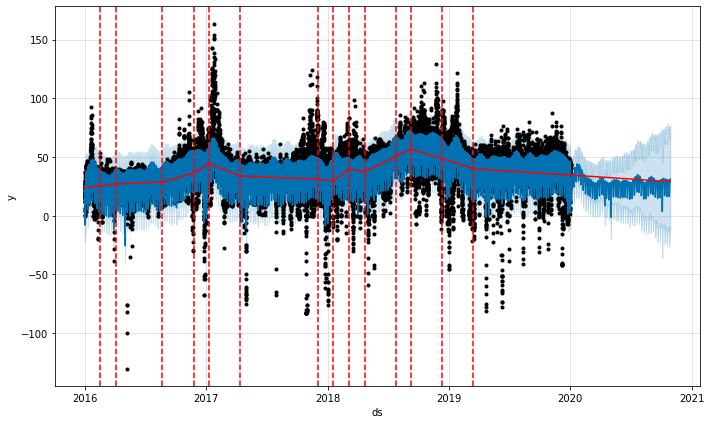

In [14]:
fig = pro.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro, forecast) 

In [15]:
pro.changepoints

1123    2016-02-16 19:00:00
2246    2016-04-03 14:00:00
3368    2016-05-20 08:00:00
4491    2016-07-06 03:00:00
5614    2016-08-21 22:00:00
6737    2016-10-07 17:00:00
7859    2016-11-23 11:00:00
8982    2017-01-09 06:00:00
10105   2017-02-25 01:00:00
11228   2017-04-12 20:00:00
12350   2017-05-29 14:00:00
13473   2017-07-15 09:00:00
14596   2017-08-31 04:00:00
15719   2017-10-16 23:00:00
16841   2017-12-02 17:00:00
17964   2018-01-18 12:00:00
19087   2018-03-06 07:00:00
20210   2018-04-22 02:00:00
21332   2018-06-07 20:00:00
22455   2018-07-24 15:00:00
23578   2018-09-09 10:00:00
24701   2018-10-26 05:00:00
25823   2018-12-11 23:00:00
26946   2019-01-27 18:00:00
28069   2019-03-15 13:00:00
Name: ds, dtype: datetime64[ns]

## Prophet on part of the data set

In [16]:
df = data_frame.copy()
x = 10000
d = 24 * 7
df_train = df[:x]
df_test = df[x:(x + d)].drop(['y'], axis = 1)
df_train.size 

20000

In [17]:
prophet = Prophet()
prophet.add_country_holidays(country_name='Germany')
prophet.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -44.3778


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22479.2     0.0458375       1531.58           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22492.9    0.00891396       271.475      0.2119           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       22498.5    0.00356058       134.513           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         22501   0.000454559       172.267           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       22502.2   0.000816701       275.781       0.122      0.9785      608   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

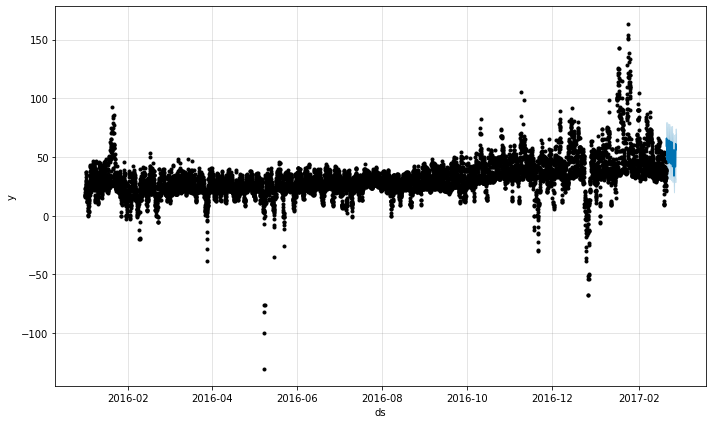

In [18]:
forecast = prophet.predict(df_test)
fig = prophet.plot(forecast)

In [19]:
y_true = df['y'][x:x+d].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 26.721


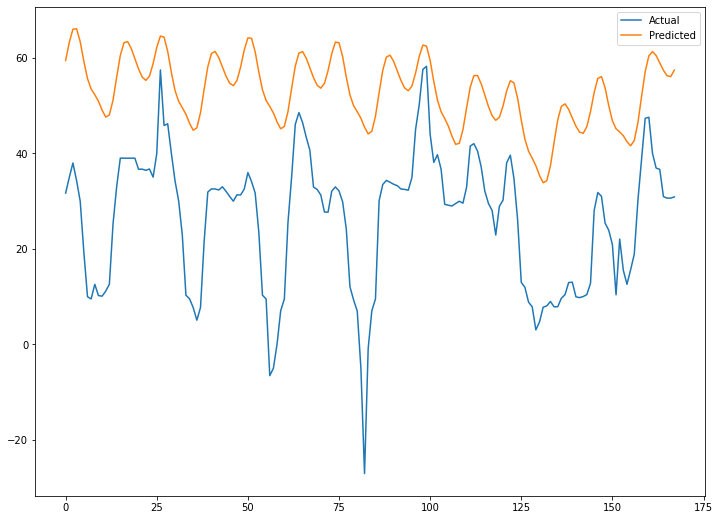

In [20]:
plt.figure(figsize=(12, 9))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

## MAPE

In [21]:
def walk_forward_validation(data, min_train):    
    
    predictions = np.array([])
    mape_list = []
    train, test = data[:min_train], data[min_train:min_train+1]
    
    for i in range(min_train,len(data)-1):
        print('Index i: {}'.format(i))
        print('Last Train Value: {}'.format(train[-1]))
        print('Test Value: {}'.format(test))
        prophet = Prophet()
        prophet.add_country_holidays(country_name='Germany')
        prophet.fit(train)
        
        # Forecast daily loads for week i
        forecast = prophet.predict(len(train)+1,len(train)+1)
        print('Predicted Value: {}'.format(forecast))
        predictions = np.concatenate((predictions, forecast),axis=None)
        # Calculate MAPE and add to mape_list
        mape_score = (abs(test-predictions[-1])/test)*100
        print('MAPE Score: {}'.format(mape_score))
        mape_list.append(mape_score)
        print('--------------')
        
        # Adjust Training and Test Data for Next Loop
        train = data[:i+1]
        if i != len(data)-2:
            test = data[i+2]
        
    return predictions, mape_list

In [22]:
data

,SPOTPrice
Time,
2016-01-01 00:00:00,23.86
2016-01-01 01:00:00,22.39
2016-01-01 02:00:00,20.59
2016-01-01 03:00:00,16.81
2016-01-01 04:00:00,17.41
...,...
2020-01-01 19:00:00,43.24
2020-01-01 20:00:00,43.47
2020-01-01 21:00:00,40.68


In [23]:
data_hourly = data_f.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')
#switch column names to prophet structure
data_hourly.rename(columns = {'Time': 'ds', 'SPOTPrice': 'y'}, inplace = True)

In [24]:
data_all = data_hourly.y[:-1]
data_5a = data_hourly.y[38735:-1]
data_1a = data_hourly.y[73799:-1]
data_6m = data_hourly.y[-4369:-1]
data_3m = data_hourly.y[-2209:-1]
data_1m = data_hourly.y[-745:-1]
data_3w = data_hourly.y[-505:-1]
data_2w = data_hourly.y[-337:-1]
data_1w = data_hourly.y[-169:-1]
data_5d = data_hourly.y[-121:-1]
data_4d = data_hourly.y[-97:-1]
data_3d = data_hourly.y[-73:-1]
data_2d = data_hourly.y[-49:-1]
data_1d = data_hourly.y[-25:-1]
#data_1w.rename(columns = {'Time': 'ds', 'SPOTPrice': 'y'}, inplace = True)

In [25]:
#pred, mape = walk_forward_validation(data_1w, 27)

In [26]:
from fbprophet.diagnostics import cross_validation
prophet = Prophet()
prophet.add_country_holidays(country_name='Germany')
prophet.fit(df_train)
df_cv = cross_validation(prophet, initial='100 days', period='10 days', horizon = '5 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -44.3778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22479.2     0.0458375       1531.58           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22492.9    0.00891396       271.475      0.2119           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       22498.5    0.00356058       134.513           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         22501   0.000454559       172.267           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       22502.2   0.000816701       275.781       0.122      0.9785      608   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Making 32 forecasts with cutoffs between 2016-04-11 15:00:00 and 2017-02-15 15:00:00


  0%|          | 0/32 [00:00<?, ?it/s]

Initial log joint probability = -18.1675
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5131.7     0.0288673       1065.31           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5166.55     0.0178419       1483.39           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5185.34    0.00485909       169.764           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5197.64     0.0435492       577.254           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5203.26    0.00134629       141.587           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -17.238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7802.4    0.00597427       380.873           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7847.77     0.0158105       211.928       1.608      0.1608      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7860.9    0.00137823       195.615           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       7866.37   0.000536707       457.599   2.387e-06       0.001      483  LS failed, Hessian reset 
     399       7871.53    0.00165085       459.231           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7876.25    0.00114879     

Initial log joint probability = -15.8931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10273     0.0177491        1163.6       0.839       0.839      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10348.4     0.0121434        574.42           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10375.7    0.00246893       518.317      0.3155      0.3155      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10387.8   0.000486811       155.771      0.8678      0.8678      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10395.1    0.00176164        86.881           1           1      605   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -17.5424
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12703.6    0.00267596       1458.43           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         12778     0.0192711       359.006           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12805.5      0.035498       362.772           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12832.9    0.00592931       876.833           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       12837.4   0.000117235       248.501   6.966e-07       0.001      580  LS failed, Hessian reset 
     499       12838.3    0.00177296    

Initial log joint probability = -18.558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       14659.7    0.00661145       423.876           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       14709.7    0.00820086       1534.44           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       14767.6     0.0316844       1429.93           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       14784.8    0.00231797       504.374      0.2455      0.2455      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       14797.1    0.00652518        337.87           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha   

Initial log joint probability = -23.7574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16956.6    0.00333155       919.589      0.9055      0.9055      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17022.4    0.00333044       262.092        1.18       0.118      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17084.5    0.00204003       178.805      0.9992      0.9992      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17117.8    0.00361079       310.448           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17127.4     0.0138375       345.846           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -56.4181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18074.4    0.00338869       670.803           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18124.2     0.0147351       1719.26           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18157.2    0.00815783       329.547           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       18205.9    0.00691254       441.281           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       18214.9     0.0058608       518.021           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -27.4615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18601.6    0.00291688       618.214      0.2947           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18628.4    0.00321146       917.852      0.2868      0.2868      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18644.7    0.00395215       591.089      0.3061      0.7826      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       18659.8     0.0110649        393.19           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       18678.1     0.0556495       514.849           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -50.5367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19376.9    0.00629116       714.655      0.6879      0.6879      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19396.5    0.00765152       347.375           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       19405.3   0.000694833       86.3374      0.8628      0.8628      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       19408.9   0.000202648        131.55     0.05886     0.05886      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       19412.7     0.0021876       878.483      0.5707      0.5707      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

Initial log joint probability = -49.7305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       21254.9     0.0141008       2191.89           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       21271.5     0.0151409       420.363          10           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         21276   0.000117349       167.336      0.5252      0.5252      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       21278.7   0.000367931       132.048           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468       21279.7   3.62893e-05       102.846   1.439e-07       0.001      616  LS failed, Hessian reset 
     499       21279.9   0.000568791    

In [27]:
import fbprophet
fbprophet.__version__

'0.7.1'